# ATIV04 ET01 - Análise do Dataset de Imagens

# 📦 Instalação de bibliotecas necessárias

___

In [1]:
!pip install opendatasets pandas imagehash scikit-image seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.7/296.7 kB 18.1 MB/s eta 0:00:00


# 📚 Importação de bibliotecas
___

In [2]:
import opendatasets as od
import os, cv2, random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, UnidentifiedImageError
import imagehash
from collections import Counter
import seaborn as sns
from IPython.display import display, Markdown

## 📂 Download e preparação do dataset


---



In [3]:
od.download("https://www.kaggle.com/datasets/trolukovich/food5k-image-dataset")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: felipebarbosadelima
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/trolukovich/food5k-image-dataset


100%|██████████| 426M/426M [00:02<00:00, 157MB/s]


In [4]:
base_dir = "./food5k-image-dataset"
subdirs = ["training", "validation", "evaluation"]

## 🔍 Verificação de Integridade dos Arquivos
____

In [5]:
def verificar_integridade(base_dir, subdirs, sample_limit=None):
  all_image_files, corrupted_images = [], []

  for subdir in subdirs:
      for root, _, files in os.walk(os.path.join(base_dir, subdir)):
          for file in files:
              if file.lower().endswith(('.png','.jpg','.jpeg')):
                  path = os.path.join(root,file)
                  all_image_files.append(path)
                  try:
                      img = Image.open(path)
                      img.verify()
                  except Exception as e:
                      corrupted_images.append((path, str(e)))

  if sample_limit:
      all_image_files = all_image_files[:sample_limit]

  df_integridade = pd.DataFrame({
      "Total Imagens":[len(all_image_files)],
      "Corrompidas":[len(corrupted_images)],
      "Válidas":[len(all_image_files) - len(corrupted_images)]
  })

  display(Markdown("### 🔍 Verificação de Integridade dos Arquivos"))
  display(df_integridade)

  return df_integridade, corrupted_images


In [6]:
df_integridade, corrompidas = verificar_integridade(base_dir, subdirs)

### 🔍 Verificação de Integridade dos Arquivos

,Total Imagens,Corrompidas,Válidas
0,5000,0,5000


## 🖼️ Análise de Formatos e Tamanhos

___



In [7]:
def analisar_formatos_tamanhos(base_dir, subdirs):
  format_counter, size_counter = Counter(), Counter()

  for subdir in subdirs:
      for root, _, files in os.walk(os.path.join(base_dir, subdir)):
          for file in files:
              if file.lower().endswith(('.png','.jpg','.jpeg')):
                  img_path = os.path.join(root,file)
                  try:
                      with Image.open(img_path) as img:
                          format_counter[img.format] += 1
                          size_counter[img.size] += 1
                  except:
                      continue

  df_formats = pd.DataFrame.from_dict(format_counter, orient="index", columns=["count"])
  df_sizes = pd.DataFrame(size_counter.most_common(10), columns=["Tamanho","Qtd"])

  display(Markdown("### 🖼️ Análise de Formatos e Tamanhos"))
  display(df_formats)
  display(df_sizes)

  return df_formats, df_sizes


In [8]:
df_formats, df_sizes = analisar_formatos_tamanhos(base_dir, subdirs)

### 🖼️ Análise de Formatos e Tamanhos

,count
JPEG,5000


,Tamanho,Qtd
0,"(512, 512)",1104
1,"(512, 384)",456
2,"(384, 512)",238
3,"(640, 480)",201
4,"(1024, 768)",201
5,"(500, 375)",201
6,"(382, 512)",128
7,"(512, 382)",102
8,"(1024, 683)",78
9,"(500, 333)",75


## 🧾 Metadados das Imagens

___


In [9]:
def analisar_metadados(base_dir, subdirs):
  metadata = []
  for subdir in subdirs:
      for root, _, files in os.walk(os.path.join(base_dir, subdir)):
          for file in files:
              if file.lower().endswith(('.png','.jpg','.jpeg')):
                  img_path = os.path.join(root, file)
                  try:
                      with Image.open(img_path) as img:
                          metadata.append({
                              "path": img_path,
                              "formato": img.format,
                              "dimensao": img.size,
                              "modo": img.mode
                          })
                  except:
                      pass

  df_meta = pd.DataFrame(metadata)
  df_meta["largura"] = df_meta["dimensao"].apply(lambda x: x[0])
  df_meta["altura"] = df_meta["dimensao"].apply(lambda x: x[1])

  display(Markdown("### 📏 Metadados das Imagens"))
  display(df_meta.describe(include="all"))

  return df_meta


In [10]:
df_meta = analisar_metadados(base_dir, subdirs)

### 📏 Metadados das Imagens

,path,formato,dimensao,modo,largura,altura
count,5000,5000,5000,5000,5000.00000,5000.000000
unique,5000,1,1074,2,NaN,NaN
top,./food5k-image-dataset/evaluation/food/141.jpg,JPEG,"(512, 512)",RGB,NaN,NaN
freq,1,5000,1104,4989,NaN,NaN
mean,NaN,NaN,NaN,NaN,599.79680,529.970600
std,NaN,NaN,NaN,NaN,313.97287,247.203085
min,NaN,NaN,NaN,NaN,160.00000,120.000000
25%,NaN,NaN,NaN,NaN,500.00000,384.000000
50%,NaN,NaN,NaN,NaN,512.00000,512.000000
75%,NaN,NaN,NaN,NaN,640.00000,512.000000


## 📉 Qualidade das Imagens
(Resolução, borradas, contraste baixo, corrompidas)

___


In [12]:
def verificar_qualidade(base_dir, subdirs, sample_size=300):
  all_images = []
  for subdir in subdirs:
      for root, _, files in os.walk(os.path.join(base_dir, subdir)):
          for file in files:
              if file.lower().endswith(('.png','.jpg','.jpeg')):
                  all_images.append(os.path.join(root, file))

  sample_images = random.sample(all_images, min(sample_size, len(all_images)))

  brightness_values, contrast_values = [], []

  for img_path in sample_images:
      try:
          img_cv = cv2.imread(img_path)
          gray = cv2.cvtColor(img_cv, cv2.COLOR_BGR2GRAY)
          brightness_values.append(np.mean(gray))
          contrast_values.append(np.std(gray))
      except:
          continue

  df_quality = pd.DataFrame({
      "Brilho": brightness_values,
      "Contraste": contrast_values
  })

  display(Markdown("### ⚡ Análise de Qualidade (Brilho e Contraste)"))
  sns.scatterplot(data=df_quality, x="Brilho", y="Contraste")
  plt.title("Distribuição de Brilho e Contraste")
  plt.show()

  return df_quality


### ⚡ Análise de Qualidade (Brilho e Contraste)

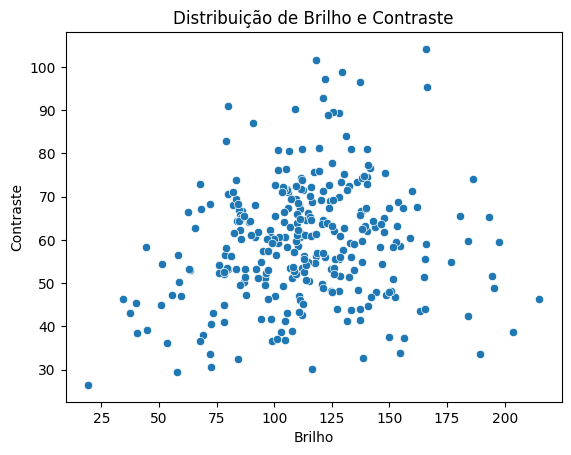

In [13]:
df_quality = verificar_qualidade(base_dir, subdirs)

## 📊 Distribuição das Classes

___

In [14]:
def distribuicao_classes(base_dir, subdirs):
  distrib = {}

  for subdir in subdirs:
      subdir_path = os.path.join(base_dir, subdir)
      files = []
      for root, _, fs in os.walk(subdir_path):
          for f in fs:
              if f.lower().endswith(('.png','.jpg','.jpeg')):
                  files.append(f)
      distrib[subdir] = len(files)

  df_distrib = pd.DataFrame.from_dict(distrib, orient="index", columns=["n_imagens"])

  display(Markdown("### 📊 Distribuição de Classes (por conjunto)"))
  display(df_distrib)

  df_distrib.plot(kind="bar", legend=False, figsize=(6,4), color="skyblue")
  plt.ylabel("Número de imagens")
  plt.title("Distribuição por Conjunto")
  plt.show()

  return df_distrib


### 📊 Distribuição de Classes (por conjunto)

,n_imagens
training,3000
validation,1000
evaluation,1000


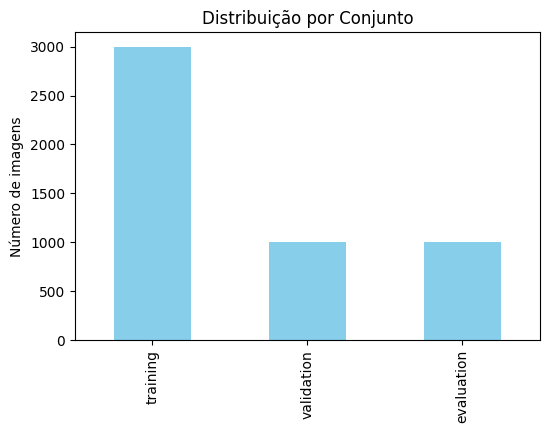

In [15]:
df_distrib = distribuicao_classes(base_dir, subdirs)

## 🔁 Detecção de Duplicatas


In [16]:
def detectar_duplicatas(base_dir, subdirs, sample_limit=500):
  image_hashes, duplicates = {}, []

  all_images = []
  for subdir in subdirs:
      for root, _, files in os.walk(os.path.join(base_dir, subdir)):
          for file in files:
              if file.lower().endswith(('.png','.jpg','.jpeg')):
                  all_images.append(os.path.join(root,file))

  sample_images = all_images[:sample_limit]

  for img_path in sample_images:
      try:
          with Image.open(img_path) as img:
              h = imagehash.average_hash(img)
              if h in image_hashes:
                  duplicates.append((img_path, image_hashes[h]))
              else:
                  image_hashes[h] = img_path
      except:
          continue

  df_dupes = pd.DataFrame(duplicates, columns=["Imagem","Duplicata"])

  display(Markdown("### 🔄 Imagens Duplicadas (Amostra)"))
  display(df_dupes.head(10))

  return df_dupes


In [17]:
df_dupes = detectar_duplicatas(base_dir, subdirs)

### 🔄 Imagens Duplicadas (Amostra)

,Imagem,Duplicata
0,./food5k-image-dataset/training/non_food/244.jpg,./food5k-image-dataset/training/non_food/549.jpg
1,./food5k-image-dataset/training/non_food/783.jpg,./food5k-image-dataset/training/non_food/358.jpg
